In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from __future__ import division

In [ ]:
#pre-processing

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('averaged_perceptron_tagger')
# nltk.download('wordnet')
import pickle

import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile

import re

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
# from spellchecker import SpellChecker

import matplotlib as mpl
import matplotlib.pyplot as plt

import numpy as np

In [37]:
def loadDataTest(path):
    df = pd.read_csv(path, thousands = ',')
#     df2 = df.drop(df.columns.difference(['Tweet_text']), axis=1)
#     df2.columns = ['Anootated tweet']
#     df2.reset_index(inplace=True, drop=True)
    
    return df

## Distribution of start ratings

### Facebook

In [3]:
reviews = loadDataTest("Facebook_review_results.csv")

In [26]:
#adding column in the df for rating category
rating_category = []

for index, row in reviews.iterrows():
    if row['reviewer_ratings'] > 3:
        rating_category.append("positive")
    if row['reviewer_ratings'] < 3:
        rating_category.append("negative")
    if row['reviewer_ratings'] == 3:
        rating_category.append("neutral")
reviews['rating_category'] = rating_category
    

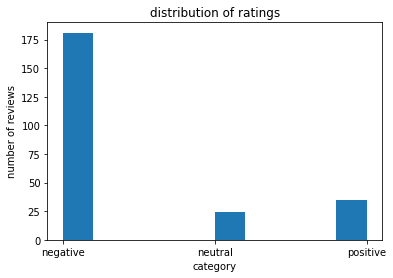

In [30]:
plt.hist(reviews['rating_category'])
plt.ylabel("number of reviews")
plt.xlabel("category")
plt.title("distribution of ratings")
plt.show()

## Analysis of main_info files

In [38]:
df_native_apps = loadDataTest("Native_android_apps_reviews/main_info_new.csv")

In [60]:
df_cross_apps = loadDataTest("Xamarin_and_React_apps_reviews/main_info.csv")

### number of ratings for each popularity category

In [42]:
df_native_apps["number_of_downloads_category"] = df_native_apps.apply (lambda row: label_popularity(row), axis=1)

In [61]:
df_cross_apps["number_of_downloads_category"] = df_cross_apps.apply (lambda row: label_popularity(row), axis=1)

In [58]:
def label_popularity (row):
    if row['number_of_downloads'] == '10,000+' or row['number_of_downloads'] == '100,000+' :
        return 1
    if row['number_of_downloads'] == '500,000+' or row['number_of_downloads'] == '5,000,000+' or row['number_of_downloads'] == '1,000,000+':
        return 2
    if row['number_of_downloads'] == '10,000,000+' or row['number_of_downloads'] == '100,000,000+' or row['number_of_downloads'] == '50,000,000+':
        return 3
    if row['number_of_downloads'] == '5,000,000,000+' or row['number_of_downloads'] == '500,000,000+' or row['number_of_downloads'] == '1,000,000,000+':
        return 4
    return 0

In [66]:


def avg_popularity(df):
    num_apps_popularity = [0,0,0,0]
    num_rating_popularity = [0,0,0,0]
    avg_rating_popularity = [0,0,0,0]

    for index, row in df.iterrows():
        if row['number_of_downloads_category'] == 1:
            num_apps_popularity[0] += 1
            num_rating_popularity[0] += row['number_of_ratings']
        if row['number_of_downloads_category'] == 2:
            num_apps_popularity[1] += 1
            num_rating_popularity[1] += row['number_of_ratings']
        if row['number_of_downloads_category'] == 3:
            num_apps_popularity[2] += 1
            num_rating_popularity[2] += row['number_of_ratings']
        if row['number_of_downloads_category'] == 4:
            num_apps_popularity[3] += 1
            num_rating_popularity[3] += row['number_of_ratings']

#     print(num_rating_popularity)
#     print(num_apps_popularity)

    return [x/y for x, y in zip(num_rating_popularity, num_apps_popularity)]


In [67]:
avg_popularity(df_native_apps)

[7322.0, 57789.26666666667, 1764889.4324324324, 6868196.642857143]

In [68]:
avg_popularity(df_cross_apps)

[747.7741935483871, 30161.1, 2020923.5, 54615198.5]

## Word Cloud

#### Manual cleaning, Stop word removal, punctuation removal, stemming

In [ ]:
def textCleaning(df):
    print(df)
    df2 = df.copy()
    stop_words = set(stopwords.words('english'))
    stop_words.difference_update({'against','did', 'didn', "didn't",'don',"don't",'off','wasn',"wasn't",'won', "won't", 'wouldn', "wouldn't", })
    ps = PorterStemmer()
    WNLemmatizer = WordNetLemmatizer()
    
#     if(train_test_flag == 'train'):
#         df3 = pd.DataFrame(columns=['Anootated tweet', 'Class'])
#     elif(train_test_flag == 'test'):
    df3 = pd.DataFrame(columns=['review'])

    for index, row in df2.iterrows():
#         row['review'] = re.sub(r'(u.s|u.s.|U.S|US)',"usa", row['Anootated tweet'])
        row['review'] = row['review'].lower()
        row['review'] = re.sub(r'(<e>|<a>|</e>|</a>|<e/>|<a/>)', " ", row['review'])
#         row['review'] = re.sub(r'http\S*', " ", row['Anootated tweet'])
        row['review'] = re.sub(r'[,\/#!$%\^&\*;:{}=\'\-_`~()><:@"“”?]',"", row['review'])
        row['review'] = re.sub(r'(facebook|Facebook|fb|FB|app|use|see|time|friend|im|post|delete|Friend|want|know)'," ", row['review'])
#         row['review'] = re.sub(r'\.'," ", ['review'])
        row['review'] = word_tokenize(row['review'])

        correct = ""
        for w in row['review']:
#             print(w)
            #pos tagging
    
            if (w in stop_words or len(w) == 1):
                continue
            tagged = nltk.pos_tag([w])
            tag = tagged[0][1]

            #lemmatize
            if tag.startswith('J'):
                tag = wn.ADJ
            elif tag.startswith('V'):
                tag = wn.VERB
            elif tag.startswith('N'):
                tag = wn.NOUN
            elif tag.startswith('R'):
                tag = wn.ADV
            else:          
                tag = wn.NOUN
            word = WNLemmatizer.lemmatize(tagged[0][0], tag)

            #stemming
            word = ps.stem(word)

            #stop word removal
            correct += " " + word
        
     
        
        df3.loc[index] = [correct]
        
        
    return df3

In [ ]:
reviews = textCleaning(reviews1)
reviews

In [ ]:
comment_words = " "
for index, row in reviews.iterrows():
    comment_words = comment_words+reviews.loc[index]['review'] + " "
    

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
#                 stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 

In [ ]:
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
#                 stopwords = stopwords, 
                min_font_size = 10).generate(comment_words)
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 